   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 12.6 MB/s eta 0:00:00
Using device: cuda
--- Curriculum Stage 1 with PER: 5x5 Maze ---
Stage 1, Episode 100, Avg Reward (last 100): 0.21
Stage 1, Episode 200, Avg Reward (last 100): 0.32
Stage 1, Episode 300, Avg Reward (last 100): 0.49
Stage 1, Episode 400, Avg Reward (last 100): 0.47
Stage 1, Episode 500, Avg Reward (last 100): 0.73
Stage 1, Episode 600, Avg Reward (last 100): 0.72
Stage 1, Episode 700, Avg Reward (last 100): 0.77
Stage 1, Episode 800, Avg Reward (last 100): 0.78
Stage 1, Episode 900, Avg Reward (last 100): 0.83
Stage 1, Episode 1000, Avg Reward (last 100): 0.80
--- Stage 1 Complete ---
--- Curriculum Stage 2 with PER: 8x8 Maze ---
Stage 2, Episode 100, Avg Reward (last 100): 0.35
Stage 2, Episode 200, Avg Reward (last 100): 0.51
Stage 2, Episode 300, Avg Reward (last 100): 0.46
Stage 2, Episode 400, Avg Reward (last 100): 0.27
Stage 2, Episode 500, Avg Reward (last 100): 0.04
Stage 2, Episode 600, Avg Reward

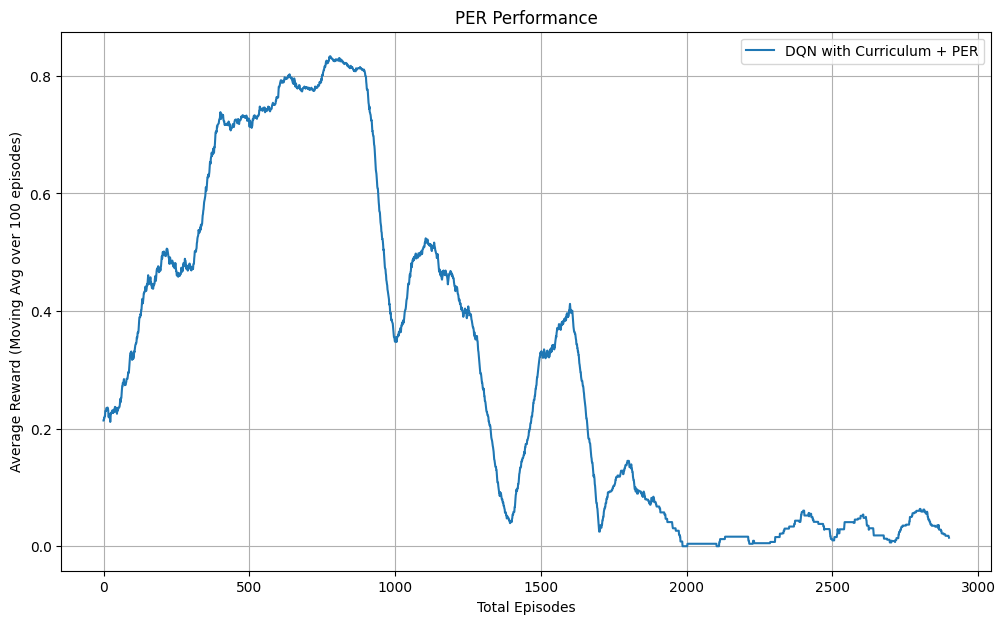

In [ ]:
!pip install minigrid
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt

# --- ハイパーパラメータ設定 ---
# カリキュラム学習の設定
MAZE_SIZES = [5, 8, 16]
EPISODES_PER_STAGE = 1000

# DQN & PER エージェントの設定
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 100000 # 探索が重要になるため、減衰を緩やかに
LEARNING_RATE = 3e-5
REPLAY_BUFFER_SIZE = 50000
BATCH_SIZE = 128
TARGET_UPDATE_FREQ = 100
# PER用のハイパーパラメータ
PER_ALPHA = 0.6
PER_BETA_START = 0.4
PER_BETA_FRAMES = 100000

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'terminated'))

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=PER_ALPHA):
        self.capacity = capacity
        self.alpha = alpha
        self.memory = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.pos = 0

    def push(self, *args):
        max_prio = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.pos] = Transition(*args)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=PER_BETA_START):
        prios = self.priorities[:len(self.memory)]
        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[i] for i in indices]

        total = len(self.memory)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, torch.tensor(weights, device=device, dtype=torch.float32)

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio + 1e-5 # 優先度が0にならないように微小値を追加

    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, obs_space_shape, action_space_n):
        super(QNetwork, self).__init__()
        h, w, c = obs_space_shape
        self.cnn = nn.Sequential(
            nn.Conv2d(c, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Flatten(),
        )
        with torch.no_grad():
            cnn_out_size = self.cnn(torch.zeros(1, c, h, w)).shape[1]
        self.fc = nn.Sequential(
            nn.Linear(cnn_out_size, 256), nn.ReLU(),
            nn.Linear(256, action_space_n)
        )

    def forward(self, x):
        x = x.to(device).float() / 255.0
        x = x.permute(0, 3, 1, 2)
        return self.fc(self.cnn(x))

class DQNAgentWithPER:
    def __init__(self, obs_space_shape, action_space_n):
        self.action_space_n = action_space_n
        self.policy_net = QNetwork(obs_space_shape, action_space_n).to(device)
        self.target_net = QNetwork(obs_space_shape, action_space_n).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.replay_buffer = PrioritizedReplayBuffer(REPLAY_BUFFER_SIZE)
        self.steps_done = 0

    def select_action(self, state):
        eps_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * self.steps_done / EPSILON_DECAY)
        self.steps_done += 1
        if random.random() > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_space_n)]], device=device, dtype=torch.long)

    def update_model(self):
        if len(self.replay_buffer) < BATCH_SIZE: return

        beta = min(1.0, PER_BETA_START + (1.0 - PER_BETA_START) * (self.steps_done / PER_BETA_FRAMES))
        transitions, indices, weights = self.replay_buffer.sample(BATCH_SIZE, beta)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)

        with torch.no_grad():
            next_q_values = torch.zeros(BATCH_SIZE, device=device)
            next_q_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
            target_q_values = reward_batch + (GAMMA * next_q_values)

        elementwise_loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1), reduction='none')
        loss = (elementwise_loss.squeeze() * weights).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        td_errors = (current_q_values.squeeze() - target_q_values).abs().detach().cpu().numpy()
        self.replay_buffer.update_priorities(indices, td_errors)

    def sync_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

if __name__ == "__main__":
    agent = None
    all_stage_rewards = {}

    for stage, size in enumerate(MAZE_SIZES):
        print(f"--- Curriculum Stage {stage + 1} with PER: {size}x{size} Maze ---")
        env = gym.make(f'MiniGrid-Empty-{size}x{size}-v0')
        env = ImgObsWrapper(env)

        if agent is None:
            agent = DQNAgentWithPER(env.observation_space.shape, env.action_space.n)

        stage_rewards = []
        for episode in range(EPISODES_PER_STAGE):
            obs, info = env.reset()
            state = torch.tensor(obs, device=device).unsqueeze(0).float()
            terminated, truncated, episode_reward = False, False, 0
            while not terminated and not truncated:
                action = agent.select_action(state)
                obs, reward, terminated, truncated, info = env.step(action.item())
                episode_reward += reward
                next_state = torch.tensor(obs, device=device).unsqueeze(0).float() if not terminated else None
                agent.replay_buffer.push(state, action, next_state, torch.tensor([reward], device=device), torch.tensor(terminated, device=device))
                state = next_state
                agent.update_model()

            stage_rewards.append(episode_reward)
            if (episode + 1) % TARGET_UPDATE_FREQ == 0:
                agent.sync_target_network()
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(stage_rewards[-100:])
                print(f"Stage {stage+1}, Episode {episode+1}, Avg Reward (last 100): {avg_reward:.2f}")

        all_stage_rewards[f"{size}x{size}"] = stage_rewards
        print(f"--- Stage {stage + 1} Complete ---")

    env.close()

    per_rewards_flat = [reward for stage_rewards in all_stage_rewards.values() for reward in stage_rewards]
    np.save("per_rewards.npy", np.array(per_rewards_flat))
    print("\nPER with Curriculum results saved to per_rewards.npy")

    plt.figure(figsize=(12, 7))
    moving_avg = np.convolve(per_rewards_flat, np.ones(100)/100, mode='valid')
    plt.plot(moving_avg, label='DQN with Curriculum + PER')
    plt.title("PER Performance")
    plt.xlabel("Total Episodes")
    plt.ylabel("Average Reward (Moving Avg over 100 episodes)")
    plt.legend()
    plt.grid(True)
    plt.savefig("per_performance.png")
    plt.show()